In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Raw SA

In [5]:
# Preprocessing for Raw SA (Outputs: df)
df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv")[["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]]
raw_df = pd.read_csv("./../../Datasets/kieranFeatures_1-30_14-Nov-2024_rawSA.csv")[["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal"]]

# Initialize Columns
df["Average Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Average Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Average Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Average Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

df["Raw Lv_1_Lo"] = np.nan
df["Raw Lv_1_Lo"] = df["Raw Lv_1_Lo"].astype(np.bool_)
df["Raw Lv_2_Lo"] = np.nan
df["Raw Lv_2_Lo"] = df["Raw Lv_2_Lo"].astype(np.bool_)
df["Raw Lv_3_Lo"] = np.nan
df["Raw Lv_3_Lo"] = df["Raw Lv_3_Lo"].astype(np.bool_)
df["Raw Tot_Lo"] = np.nan
df["Raw Tot_Lo"] = df["Raw Tot_Lo"].astype(np.bool_)

raw_df["Lv_1_Lo"] = (raw_df["SA1"] < 5).astype(np.bool_)
raw_df["Lv_2_Lo"] = (raw_df["SA2"] < 5).astype(np.bool_)
raw_df["Lv_3_Lo"] = (raw_df["SA3"] < 5).astype(np.bool_)
raw_df["Tot_Lo"] = (raw_df["SAtotal"] < 15).astype(np.bool_)

# Merge Outcome Values
for index, row in df.iterrows():
    id = row["ID"]
    trial_num = row["trialNum"]

    if raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Lv_1_Lo"].values.size > 0:
        df.loc[index, "Raw Lv_1_Lo"] = raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Lv_1_Lo"].values[0]
        df.loc[index, "Raw Lv_2_Lo"] = raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Lv_2_Lo"].values[0]
        df.loc[index, "Raw Lv_3_Lo"] = raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Lv_3_Lo"].values[0]
        df.loc[index, "Raw Tot_Lo"] = raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Tot_Lo"].values[0]
    
# Free Up Memory
del id, index, raw_df, row, trial_num
df = df.drop(columns = ["SA1", "SA2", "SA3", "SAtotal"])

In [5]:
df["High to Low SA 1"] = ~df["Raw Lv_1_Lo"] & df["Average Lv_1_Lo"]
df["High to Low SA 2"] = ~df["Raw Lv_2_Lo"] & df["Average Lv_2_Lo"]
df["High to Low SA 3"] = ~df["Raw Lv_3_Lo"] & df["Average Lv_3_Lo"]
df["High to Low SA Total"] = ~df["Raw Tot_Lo"] & df["Average Tot_Lo"]

df["Low to High SA 1"] = df["Raw Lv_1_Lo"] & ~df["Average Lv_1_Lo"]
df["Low to High SA 2"] = df["Raw Lv_2_Lo"] & ~df["Average Lv_2_Lo"]
df["Low to High SA 3"] = df["Raw Lv_3_Lo"] & ~df["Average Lv_3_Lo"]
df["Low to High SA Total"] = df["Raw Tot_Lo"] & ~df["Average Tot_Lo"]

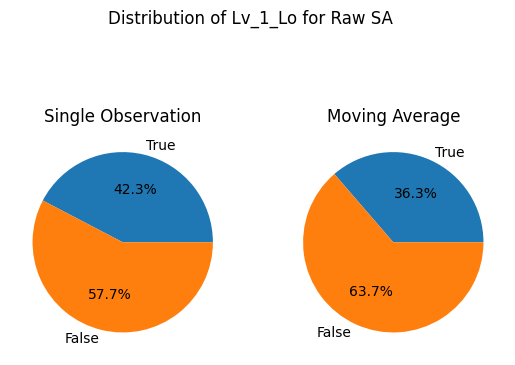

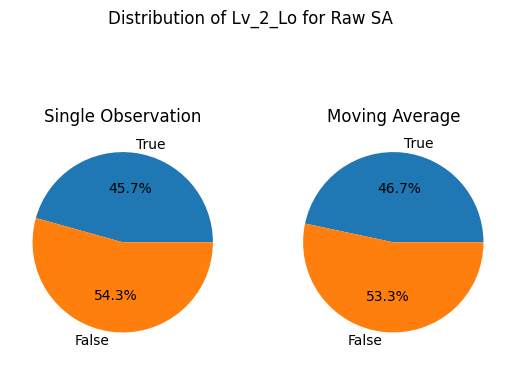

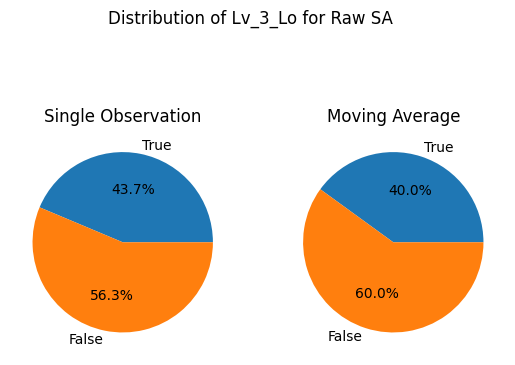

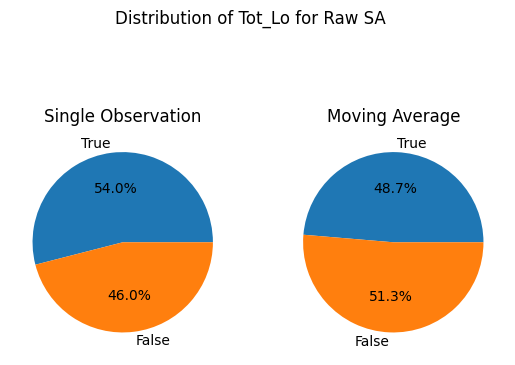

In [ ]:
for avg_lvl, raw_lvl, lvl in [("Average Lv_1_Lo", "Raw Lv_1_Lo", "Lv_1_Lo"), ("Average Lv_2_Lo", "Raw Lv_2_Lo", "Lv_2_Lo"), ("Average Lv_3_Lo", "Raw Lv_3_Lo", "Lv_3_Lo"), ("Average Tot_Lo", "Raw Tot_Lo", "Tot_Lo")]:
    single_true_count = np.sum(df[raw_lvl])
    single_false_count = np.sum(~df[raw_lvl])
    avg_true_count = np.sum(df[avg_lvl])
    avg_false_count = np.sum(~df[avg_lvl])

    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Distribution of " + lvl + " for Raw SA")
    ax[0].pie([single_true_count, single_false_count], labels = ["True", "False"], autopct = "%1.1f%%")
    ax[0].set_title("Single Observation")
    ax[1].pie([avg_true_count, avg_false_count], labels = ["True", "False"], autopct = "%1.1f%%")
    ax[1].set_title("Moving Average")

In [10]:
n_rows = df.shape[0]

for high_to_low_lvl, low_to_high_lvl in [("High to Low SA 1", "Low to High SA 1"), ("High to Low SA 2", "Low to High SA 2"), ("High to Low SA 3", "Low to High SA 3"), ("High to Low SA Total", "Low to High SA Total")]:
    print("Overall Change:", round((np.sum(df[low_to_high_lvl]) + np.sum(df[high_to_low_lvl])) / n_rows * 100, 1))
    print("1 to 0:", round(np.sum(df[low_to_high_lvl]) / n_rows * 100, 1))
    print("0 to 1:", round(np.sum(df[high_to_low_lvl]) / n_rows * 100, 1))
    print()

Overall Change: 26.0
1 to 0: 16.0
0 to 1: 10.0

Overall Change: 34.3
1 to 0: 16.7
0 to 1: 17.7

Overall Change: 27.7
1 to 0: 15.7
0 to 1: 12.0

Overall Change: 25.3
1 to 0: 15.3
0 to 1: 10.0



# Adjusted SA

In [6]:
# Preprocessing for Adjusted SA
# SPLITS FOR ADJUSTED SA:
# Moving Average:
# SA 1 -> 36th percentile
# SA 2 -> 47th percentile
# SA 3 -> 40th percentile
# SA Total -> 49th percentile

# Single Observation:
# SA 1 -> 28th percentile
# SA 2 -> 35th percentile
# SA 3 -> 30th percentile
# SA Total -> 42nd percentile

df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3.csv")[["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]]
raw_df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_24-Jan-2025.csv")[["ID", "trialNum", "adjSA1", "adjSA2", "adjSA3", "adjSAtotal"]]

# Initialize Columns
df["Average Lv_1_Lo"] = (df["adjSA1"] < np.percentile(df["adjSA1"], 36)).astype(np.bool_)
df["Average Lv_2_Lo"] = (df["adjSA2"] < np.percentile(df["adjSA2"], 47)).astype(np.bool_)
df["Average Lv_3_Lo"] = (df["adjSA3"] < np.percentile(df["adjSA3"], 40)).astype(np.bool_)
df["Average Tot_Lo"] = (df["adjSAtotal"] < np.percentile(df["adjSAtotal"], 49)).astype(np.bool_)

df["Raw Lv_1_Lo"] = np.nan
df["Raw Lv_1_Lo"] = df["Raw Lv_1_Lo"].astype(np.bool_)
df["Raw Lv_2_Lo"] = np.nan
df["Raw Lv_2_Lo"] = df["Raw Lv_2_Lo"].astype(np.bool_)
df["Raw Lv_3_Lo"] = np.nan
df["Raw Lv_3_Lo"] = df["Raw Lv_3_Lo"].astype(np.bool_)
df["Raw Tot_Lo"] = np.nan
df["Raw Tot_Lo"] = df["Raw Tot_Lo"].astype(np.bool_)

raw_df["Lv_1_Lo"] = (raw_df["adjSA1"] < np.percentile(raw_df["adjSA1"], 28)).astype(np.bool_)
raw_df["Lv_2_Lo"] = (raw_df["adjSA2"] < np.percentile(raw_df["adjSA2"], 35)).astype(np.bool_)
raw_df["Lv_3_Lo"] = (raw_df["adjSA3"] < np.percentile(raw_df["adjSA3"], 30)).astype(np.bool_)
raw_df["Tot_Lo"] = (raw_df["adjSAtotal"] < np.percentile(raw_df["adjSAtotal"], 42)).astype(np.bool_)

# Merge Outcome Values
for index, row in df.iterrows():
    id = row["ID"]
    trial_num = row["trialNum"]

    if raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Lv_1_Lo"].values.size > 0:
        df.loc[index, "Raw Lv_1_Lo"] = raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Lv_1_Lo"].values[0]
        df.loc[index, "Raw Lv_2_Lo"] = raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Lv_2_Lo"].values[0]
        df.loc[index, "Raw Lv_3_Lo"] = raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Lv_3_Lo"].values[0]
        df.loc[index, "Raw Tot_Lo"] = raw_df[(raw_df["ID"] == id) & (raw_df["trialNum"] == trial_num)]["Tot_Lo"].values[0]
    
# Free Up Memory
del id, index, raw_df, row, trial_num
df = df.drop(columns = ["adjSA1", "adjSA2", "adjSA3", "adjSAtotal"])

In [7]:
df["High to Low SA 1"] = ~df["Raw Lv_1_Lo"] & df["Average Lv_1_Lo"]
df["High to Low SA 2"] = ~df["Raw Lv_2_Lo"] & df["Average Lv_2_Lo"]
df["High to Low SA 3"] = ~df["Raw Lv_3_Lo"] & df["Average Lv_3_Lo"]
df["High to Low SA Total"] = ~df["Raw Tot_Lo"] & df["Average Tot_Lo"]

df["Low to High SA 1"] = df["Raw Lv_1_Lo"] & ~df["Average Lv_1_Lo"]
df["Low to High SA 2"] = df["Raw Lv_2_Lo"] & ~df["Average Lv_2_Lo"]
df["Low to High SA 3"] = df["Raw Lv_3_Lo"] & ~df["Average Lv_3_Lo"]
df["Low to High SA Total"] = df["Raw Tot_Lo"] & ~df["Average Tot_Lo"]

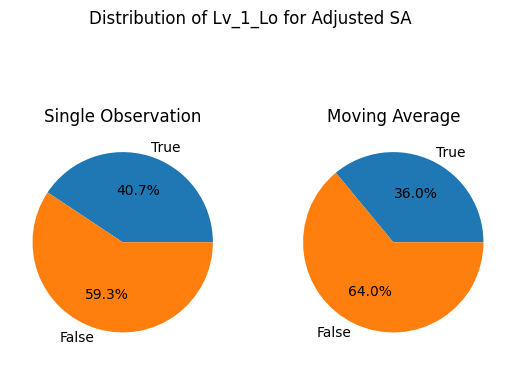

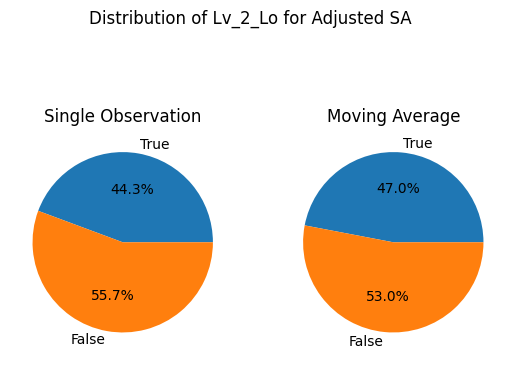

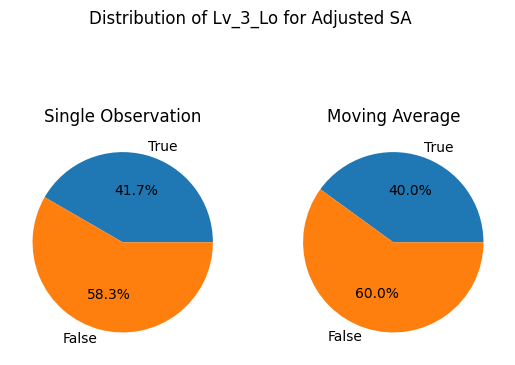

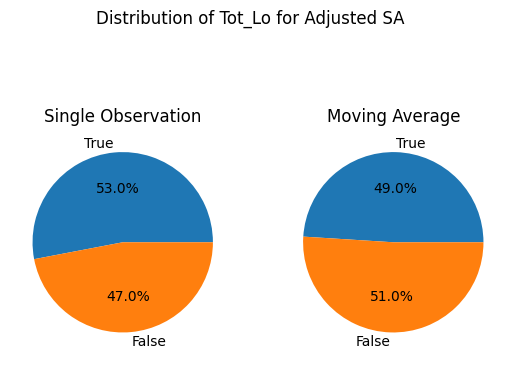

In [9]:
for avg_lvl, raw_lvl, lvl in [("Average Lv_1_Lo", "Raw Lv_1_Lo", "Lv_1_Lo"), ("Average Lv_2_Lo", "Raw Lv_2_Lo", "Lv_2_Lo"), ("Average Lv_3_Lo", "Raw Lv_3_Lo", "Lv_3_Lo"), ("Average Tot_Lo", "Raw Tot_Lo", "Tot_Lo")]:
    single_true_count = np.sum(df[raw_lvl])
    single_false_count = np.sum(~df[raw_lvl])
    avg_true_count = np.sum(df[avg_lvl])
    avg_false_count = np.sum(~df[avg_lvl])

    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Distribution of " + lvl + " for Adjusted SA")
    ax[0].pie([single_true_count, single_false_count], labels = ["True", "False"], autopct = "%1.1f%%")
    ax[0].set_title("Single Observation")
    ax[1].pie([avg_true_count, avg_false_count], labels = ["True", "False"], autopct = "%1.1f%%")
    ax[1].set_title("Moving Average")

In [10]:
n_rows = df.shape[0]

for high_to_low_lvl, low_to_high_lvl in [("High to Low SA 1", "Low to High SA 1"), ("High to Low SA 2", "Low to High SA 2"), ("High to Low SA 3", "Low to High SA 3"), ("High to Low SA Total", "Low to High SA Total")]:
    print("Overall Change:", round((np.sum(df[low_to_high_lvl]) + np.sum(df[high_to_low_lvl])) / n_rows * 100, 1))
    print("1 to 0:", round(np.sum(df[low_to_high_lvl]) / n_rows * 100, 1))
    print("0 to 1:", round(np.sum(df[high_to_low_lvl]) / n_rows * 100, 1))
    print()

Overall Change: 25.3
1 to 0: 15.0
0 to 1: 10.3

Overall Change: 30.7
1 to 0: 14.0
0 to 1: 16.7

Overall Change: 27.7
1 to 0: 14.7
0 to 1: 13.0

Overall Change: 26.7
1 to 0: 15.3
0 to 1: 11.3

